# Trabalho Sistemas Inteligentes

Membros:

André Yuji Sakuma-11201920463

Dennis Lopes da Silva Matozo-11201810444

Henrique Queiroz Reuter-11201812261

In [1]:
!pip install pybaseball

'pip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


## Objetivo

Vamos tentar prever os tipos de arremessos do Shohei Ohtani usando algumas métricas, todas as estatísticas são retiradas da biblioteca pybaseball

In [2]:
import numpy as np
import sklearn
import pybaseball
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

Pegamos a chave de identificação do jogador, para então buscarmos suas estatísticas

In [4]:
playerid_lookup('ohtani', 'shohei')

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,ohtani,shohei,660271,ohtas001,ohtansh01,19755,2018.0,2023.0


## Para ver as datas específicas dos jogos que o Shohei Ohtani arremessou na temporada de 2022, olhamos esse link:
https://www.baseball-reference.com/players/gl.fcgi?id=ohtansh01&t=p&year=2022

Vamos fazer a análise com todos os jogos que ele arremessou na temporada de 2022

In [5]:
ohtani_stats = statcast_pitcher('2022-04-07', '2022-10-06', 660271)
print(ohtani_stats)

Gathering Player Data
     pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0            ST  2022-10-05           84.7          -2.67           5.61   
1            ST  2022-10-05           83.9          -2.53           5.58   
2            ST  2022-10-05           84.4          -2.55           5.65   
3            CU  2022-10-05           74.3          -1.84           6.20   
4            ST  2022-10-05           85.6          -2.49           5.58   
...         ...         ...            ...            ...            ...   
2624         FS  2022-04-07           91.8          -1.76           6.04   
2625         ST  2022-04-07           86.9          -2.29           5.77   
2626         FF  2022-04-07           99.2          -2.13           5.87   
2627         FF  2022-04-07           97.9          -2.16           5.89   
2628         FF  2022-04-07           99.8          -2.19           5.82   

         player_name  batter  pitcher     events      description

In [6]:
ohtani_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pitch_type                       2629 non-null   object 
 1   game_date                        2629 non-null   object 
 2   release_speed                    2629 non-null   float64
 3   release_pos_x                    2629 non-null   float64
 4   release_pos_z                    2629 non-null   float64
 5   player_name                      2629 non-null   object 
 6   batter                           2629 non-null   int64  
 7   pitcher                          2629 non-null   int64  
 8   events                           661 non-null    object 
 9   description                      2629 non-null   object 
 10  spin_dir                         0 non-null      float64
 11  spin_rate_deprecated             0 non-null      float64
 12  break_angle_deprecat

Aqui está a sigla para cada tipo de arremesso que ele lançou no ano de 2022

In [7]:
tipos_arremesso = ohtani_stats.pitch_type
print(set(tipos_arremesso))

{'CU', 'ST', 'FF', 'FS', 'CS', 'SI', 'SL', 'FC'}


ST-Sweeper

CH-Changeup

SI-Sinker

CU-Curveball

SL-Slider

FF-Four Seam Fastball

FS-Splitter/Split-Finger

FC-Cutter

CS-Slow Curve

In [8]:
print(set(ohtani_stats.pitch_name))

{'Sinker', '4-Seam Fastball', 'Sweeper', 'Slider', 'Cutter', 'Split-Finger', 'Slow Curve', 'Curveball'}


## Pré-processamento
Pegamos as features que julgamos ser mais relevantes para tentarmos acertar o nosso target, que é o tipo de arrremeso

In [13]:
x = ['pitch_type','release_speed','release_pos_x','release_pos_z','description','zone','type','effective_speed']

Tiramos de ohtani_stats todas as colunas que não estão em x

In [14]:
for i in ohtani_stats.columns:
   if i not in x:
       ohtani_stats = ohtani_stats.drop(columns=i)

Ficamos apenas com essas colunas, iremos adicionar mais algumas para melhorarmos nossa busca

In [15]:
ohtani_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pitch_type       2629 non-null   object 
 1   release_speed    2629 non-null   float64
 2   release_pos_x    2629 non-null   float64
 3   release_pos_z    2629 non-null   float64
 4   description      2629 non-null   object 
 5   zone             2629 non-null   int64  
 6   type             2629 non-null   object 
 7   effective_speed  2629 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 164.4+ KB


Adiciona-se:coluna do tipo de arremesso anterior

In [16]:
ohtani_stats['previous_pitch_type'] = 'nan'
for i in range(1,ohtani_stats.shape[0]):
    ohtani_stats.previous_pitch_type[i] = ohtani_stats.pitch_type[i-1]


C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\2742460137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_pitch_type[i] = ohtani_stats.pitch_type[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\2742460137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_pitch_type[i] = ohtani_stats.pitch_type[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\2742460137.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Adiciona-se:coluna do acontecimento anterior

In [17]:
ohtani_stats['previous_description'] = 'nan'
for i in range(1,ohtani_stats.shape[0]):
    ohtani_stats.previous_description[i] = ohtani_stats.description[i-1]

C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\337060339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_description[i] = ohtani_stats.description[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\337060339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_description[i] = ohtani_stats.description[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\337060339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Adiciona-se:coluna do resultado do arremesso anterior:

B-Bola(Lançou fora da zona de strike)

S-Strike(Lançou dentro da zona de strike)

X-Strikeout(eliminou um rebatedor com um strike)

In [18]:
ohtani_stats['previous_type'] = 'nan'
for i in range(1,ohtani_stats.shape[0]):
    ohtani_stats.previous_type[i] = ohtani_stats.type[i-1]

C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\3804891978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_type[i] = ohtani_stats.type[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\3804891978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohtani_stats.previous_type[i] = ohtani_stats.type[i-1]
C:\Users\dedre\AppData\Local\Temp\ipykernel_3220\3804891978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

Temos uma base de dados final com 11 features, uma grande redução da que tínhamos inicialmente(ela possuía 92 features no começo)

In [19]:
ohtani_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2629 entries, 0 to 2628
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pitch_type            2629 non-null   object 
 1   release_speed         2629 non-null   float64
 2   release_pos_x         2629 non-null   float64
 3   release_pos_z         2629 non-null   float64
 4   description           2629 non-null   object 
 5   zone                  2629 non-null   int64  
 6   type                  2629 non-null   object 
 7   effective_speed       2629 non-null   float64
 8   previous_pitch_type   2629 non-null   object 
 9   previous_description  2629 non-null   object 
 10  previous_type         2629 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 226.1+ KB


## Qual é a porcentagem de cada arremesso que o Shohei Ohtani teve em 2022 ?
Pegamos a quantidade total de cada arremesso e sua porcentagem 

Tipo Sweeper:

In [20]:
vetor_st = []
count_st = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'ST':
        vetor_st.insert(count_st,ohtani_stats.release_speed[i])
        count_st += 1


print(len(vetor_st))
print(np.mean(vetor_st))
print(len(vetor_st)/len(ohtani_stats.pitch_type))

983
85.33641912512718
0.37390642829973375


Tipo Four-Seam Fastball

In [21]:
vetor_ff = []
count_ff = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'FF':
        vetor_ff.insert(count_ff,ohtani_stats.release_speed[i])
        count_ff += 1

print(len(vetor_ff))
print(np.mean(vetor_ff))
print(len(vetor_ff)/len(ohtani_stats.pitch_type))

718
97.27061281337046
0.2731076454925827


Tipo Sinker:

In [22]:
vetor_si = []
count_si = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'SI':
        vetor_si.insert(count_si,ohtani_stats.release_speed[i])
        count_si += 1

print(len(vetor_si))
print(np.mean(vetor_si))
print(len(vetor_si)/len(ohtani_stats.pitch_type))

97
97.16082474226806
0.03689615823507037


Tipo Slow Curve

In [23]:
vetor_cs = []
count_cs = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'CS':
        vetor_cs.insert(count_cs,ohtani_stats.release_speed[i])
        count_cs += 1

print(len(vetor_cs))
print(np.mean(vetor_cs))
print(len(vetor_cs)/len(ohtani_stats.pitch_type))

1
67.9
0.0003803727653100038


Tipo Curveball:

In [24]:
vetor_cu = []
count_cu = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'CU':
        vetor_cu.insert(count_cu,ohtani_stats.release_speed[i])
        count_cu += 1

print(len(vetor_cu))
print(np.mean(vetor_cu))
print(len(vetor_cu)/len(ohtani_stats.pitch_type))

222
77.67972972972974
0.08444275389882085


Tipo Splitter:

In [25]:
vetor_fs = []
count_fs = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'FS':
        vetor_fs.insert(count_cu,ohtani_stats.release_speed[i])
        count_fs += 1

print(len(vetor_fs))
print(np.mean(vetor_fs))
print(len(vetor_fs)/len(ohtani_stats.pitch_type))

312
89.29134615384616
0.11867630277672118


Tipo Cutter:

In [26]:
vetor_fc = []
count_fc = 0
for i in range(0,ohtani_stats.shape[0]):
    if ohtani_stats.pitch_type[i] == 'FC':
        vetor_fc.insert(count_fc,ohtani_stats.release_speed[i])
        count_fc += 1

print(len(vetor_fc))
print(np.mean(vetor_fc))
print(len(vetor_fc)/len(ohtani_stats.pitch_type))

233
90.7420600858369
0.08862685431723089


Gráfico com a quantidade de arremessos de cada um

Text(0.5, 0.98, 'Quantidade de arremessos')

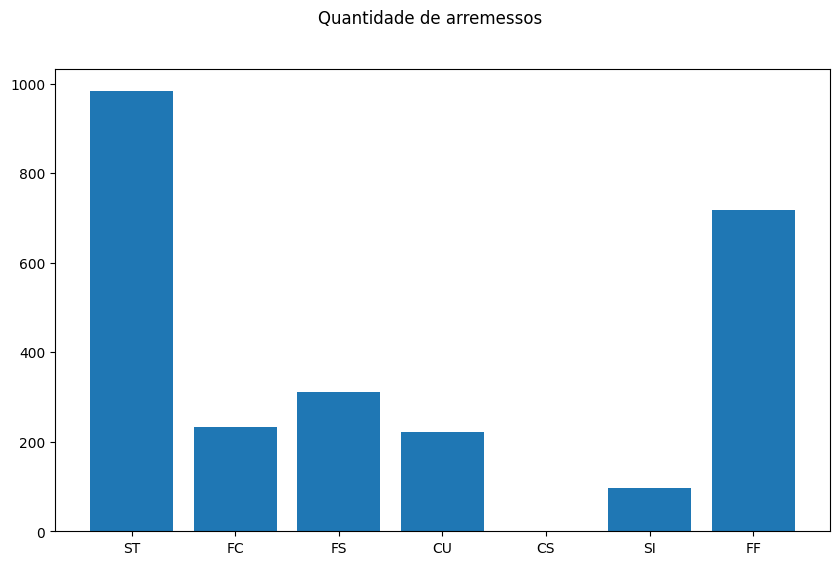

In [27]:
data = {'ST': len(vetor_st), 'FC': len(vetor_fc), 'FS': len(vetor_fs), 'CU': len(vetor_cu), 'CS': len(vetor_cs),'SI':len(vetor_si),'FF':len(vetor_ff)}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
axs.bar(names,values)
fig.suptitle('Quantidade de arremessos')

Vamos fazer um primeiro teste usando o classificador knn com uma separação de dados padrão

Tratamento dos dados

In [28]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
obj_list = ohtani_stats.select_dtypes(include='object').columns
for feature in obj_list:
    ohtani_stats[feature] = lb.fit_transform(ohtani_stats[feature])

## Teste com 3 algoritmos usando o método de separação tts

Geramos 10 sets de teste diferentes para a avaliação dos algoritmos de classificação, o tamanho do teste foi de 25%

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

x = ohtani_stats.drop(columns='pitch_type')
y = ohtani_stats['pitch_type']


X_trains = []
X_tests = []
y_trains = []
y_tests = []

# Gera 10 sets de testes diferentes para ser utilizado no treinamento e avaliação dos algoritmos
for i in range(10):
  X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25, shuffle=True)
  X_trains.append(X_train)
  X_tests.append(X_test)
  y_trains.append(y_train)
  y_tests.append(y_test)

KNN-Geramos um gráfico da porcentagem de acertos x número de vizinhos usados

Testamos com no máximo 50 vizinhos, e pegamos a média dos 10 testes de cada quantidade de vizinhos

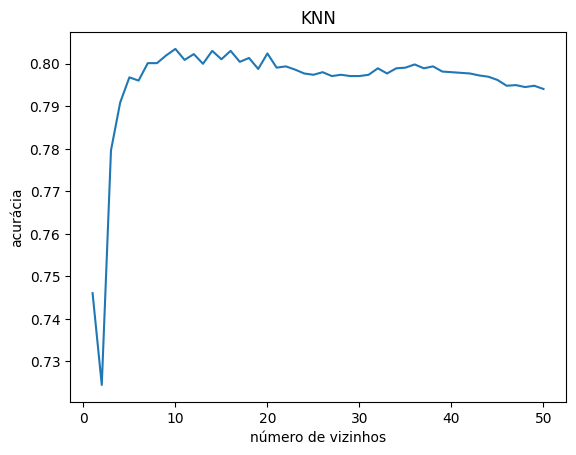

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def neighbor_normalization(n):
  return n + 1

neighbors_arr = []

for j in range(50):
  knn_accuracy = []
  for i in range(10):
    knn = KNeighborsClassifier(n_neighbors=neighbor_normalization(j))
    knn.fit(X_trains[i], y_trains[i])
    y_pred = knn.predict(X_tests[i])
    knn_accuracy.append(accuracy_score(y_tests[i],y_pred))

  # Acurácia média dos 10 testes

  neighbors_arr.append(np.mean(knn_accuracy))

plt.plot(list(map(neighbor_normalization, range(50))), neighbors_arr)
plt.title('KNN')
plt.ylabel('acurácia')
plt.xlabel('número de vizinhos')
plt.show()


SVC-Geramos uma gráfico da porcentagem de acertos x parâmetro de regularização

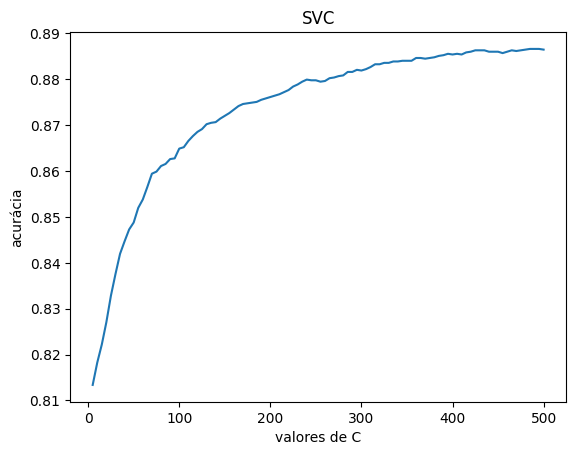

In [31]:
from sklearn.svm import SVC

def C_normalization(n):
  return (n+1) *5

C_arr = []
for j in range(100):
  svm_accuracy = []
  for i in range(10):
    SVM = SVC(C=C_normalization(j),kernel='poly',degree=3)
    SVM.fit(X_trains[i], y_trains[i])
    y_pred = SVM.predict(X_tests[i])
    svm_accuracy.append(accuracy_score(y_tests[i], y_pred))

  # Acurácia média dos 10 testes
  C_arr.append(np.mean(svm_accuracy))

plt.plot(list(map(C_normalization, range(100))), C_arr)
plt.title('SVC')
plt.ylabel('acurácia')
plt.xlabel('valores de C')
plt.show()

MLP-Geramos o gráfico de porcentagem de acertos x a quantidade de nuerônios na camada intermediária

Fizemos uso do adam como algoritmo no classificador

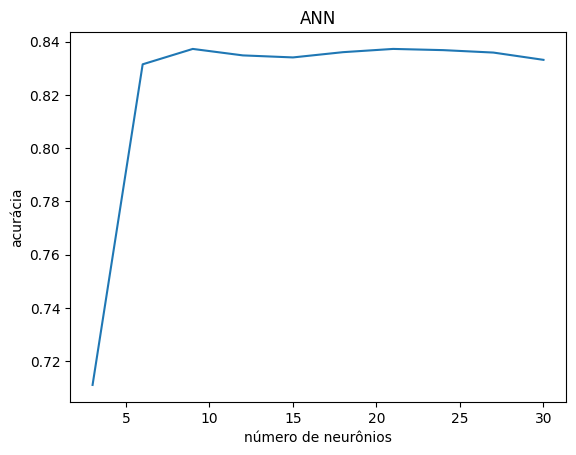

In [32]:
from sklearn.neural_network import MLPClassifier

def neurons_normalization(n):
  return (n+1) * 3

neurons_arr = []

for j in range(10):
  cla_accuracy = []
  for i in range(10):
    CLA = MLPClassifier(solver='adam',hidden_layer_sizes=(neurons_normalization(j)),activation='logistic', max_iter=1000000)
    CLA.fit(X_trains[i], y_trains[i])
    y_pred = CLA.predict(X_tests[i])
    cla_accuracy.append(accuracy_score(y_tests[i], y_pred))

  # Acurácia média dos 10 testes
  neurons_arr.append(np.mean(cla_accuracy))

plt.plot(list(map(neurons_normalization, range(10))), neurons_arr)
plt.title('ANN')
plt.ylabel('acurácia')
plt.xlabel('número de neurônios')
plt.show()


### Gerando uma amostragem com os melhores casos escolhidos arbitrariamente para cada um dos algoritmos

Pegamos a melhor quantidade de vizinhos no KNN, o melhor coeficiente do SVM e a melhor quantidade de neurônios do ANN, baseado nos resultados apresentados nos gráficos

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import imshow

best_KNN_neighbor = 10
best_SVC_C = 300
best_ANN_neurons = 10

knn = KNeighborsClassifier(n_neighbors=best_KNN_neighbor)
SVM = SVC(C=best_SVC_C,kernel='poly',degree=3)
CLA = MLPClassifier(solver='adam',hidden_layer_sizes=(best_ANN_neurons),activation='logistic', max_iter=1000000)

knn.fit(X_trains[0], y_trains[0])
SVM.fit(X_trains[0], y_trains[0])
CLA.fit(X_trains[0], y_trains[0])

knn_pred = knn.predict(X_tests[0])
SVM_pred = SVM.predict(X_tests[0])
CLA_pred = CLA.predict(X_tests[0])

knn_score = accuracy_score(y_tests[0], knn_pred)
SVM_score = accuracy_score(y_tests[0], SVM_pred)
CLA_score = accuracy_score(y_tests[0], CLA_pred)

### Definição da funcão heatmap, conforme especificado em:
[Heatmap with annotations](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [34]:
from matplotlib.ticker import StrMethodFormatter

# Usamos a implementação dessas duas funções conforme especificado em
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

### Labels dos tipos de lançamentos

In [35]:
pitch_map = {
    0: 'CS',
    1: 'CU',
    2: 'FC',
    3: 'FF',
    4: 'FS',
    5: 'SI',
    6: 'SL',
    7: 'ST'
}

pitch_types = list(pitch_map.values())

print(pitch_types)


['CS', 'CU', 'FC', 'FF', 'FS', 'SI', 'SL', 'ST']


### Resultados do KNN

=====KNN=====
Acurácia:  81.15501519756839 %
Matriz de confusão:


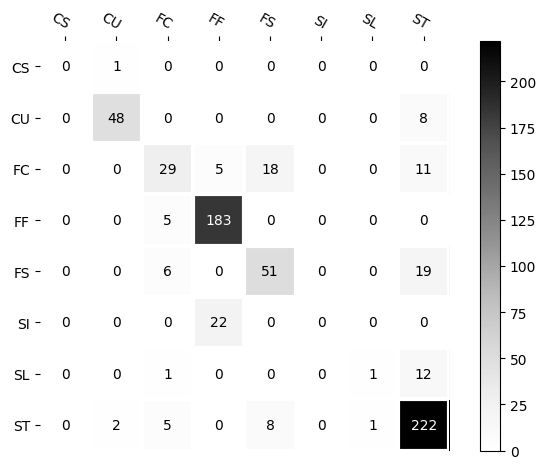

In [36]:
print('=====KNN=====')
print('Acurácia: ', knn_score * 100, '%')
print('Matriz de confusão:')

cm = confusion_matrix(list(map(lambda x: pitch_types[x],y_tests[0])), list(map(lambda x: pitch_types[x], knn_pred)), labels=pitch_types)

fig, ax = plt.subplots()

im, cbar = heatmap(cm, pitch_types, pitch_types, cmap="Greys")
texts = annotate_heatmap(im, valfmt="{x:d}")

fig.tight_layout()
plt.show()


### Resultados do SVM

=====SVC=====
Acurácia:  88.29787234042553 %
Matriz de confusão:


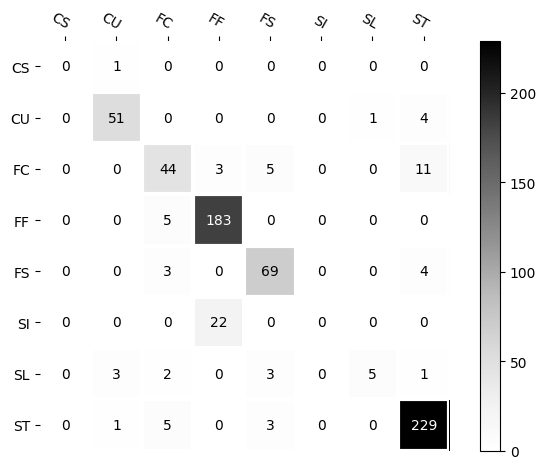

In [37]:
print('=====SVC=====')
print('Acurácia: ', SVM_score * 100, '%')
print('Matriz de confusão:')

cm = confusion_matrix(list(map(lambda x: pitch_types[x],y_tests[0])), list(map(lambda x: pitch_types[x], SVM_pred)), labels=pitch_types)

fig, ax = plt.subplots()

im, cbar = heatmap(cm, pitch_types, pitch_types, cmap="Greys")
texts = annotate_heatmap(im, valfmt="{x:d}")

fig.tight_layout()
plt.show()


### Resultados da Rede Neural

=====CLA=====
Acurácia:  83.58662613981764 %
Matriz de confusão:


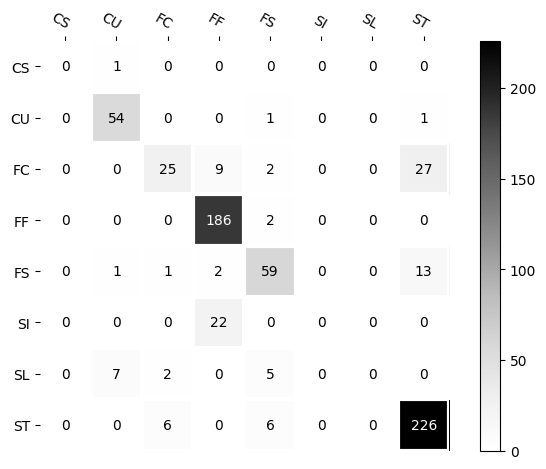

In [38]:

print('=====CLA=====')
print('Acurácia: ', CLA_score * 100, '%')
print('Matriz de confusão:')

cm = confusion_matrix(list(map(lambda x: pitch_types[x],y_tests[0])), list(map(lambda x: pitch_types[x], CLA_pred)), labels=pitch_types)

fig, ax = plt.subplots()

im, cbar = heatmap(cm, pitch_types, pitch_types, cmap="Greys")
texts = annotate_heatmap(im, valfmt="{x:d}")

fig.tight_layout()
plt.show()

## Discussão:

Podemos analisar que nenhum dos três classificadores chegou ha 90% de acurácia, algumas razões podem explicar esse fato:

1º razão = Poderíamos ter usado um número diferente de features para tentarmos obter o tipo de arremesso como target, uma revisão da literatura quanto a isso pode ser de grande ajuda.

2º razão = Realizar a escolha de features diferentes para a predição do nosso target.

3º razão = Aumentar o tempo de análise do Shohei Ohtani, isso nos proporcionaria uma quantidade maior de arremessos, o que poderia aprimorar o desempenho de nossos classificadores.

4º razão = Poderíamos ter usado uma quantidade diferente de testes ao invés de 10.

## Análise dos Resultados:

-KNN demonstrou o seu melhor desempenho na faixa de 9 a 11 vizinhos analisados, tendo em vista que conforme houve aumento da quantidade de vizinhos, observou-se piora no desempenho.

-Support Vector Machine apresentou melhora de desempenho exponencial a medida em que o coeficiente(que está normalizado)foi sendo aumentado, no gráfico é nítido a conclusão de uma melhora de desempenho.

-ANN teve seu resultado melhor com 10 neurônios, e depois sua acurácia ficou linear independente da quantidade de neurônios.

## Conclusão:

Os resultados obtidos não foram satisfatórios, tendo em vista que esperávamos uma acurácia superior a 90%, para trabalhos futuros é interessante testarmos os classificadores realizando algumas das mudanças que foram sugeridas por nós mesmos na "Discussão". Junto disso, usar outros algoritmos de classificação, e até mesmo um processo de clusterização dos tipos de arremesso, tendo como objetivo a melhora das previssões.

## Links importantes:

https://github.com/schorrm/pybaseball

https://www.mlb.com/glossary/pitch-types

https://library.fangraphs.com/pitch-type-abbreviations-classifications/

https://pypi.org/project/pybaseball/2.0.0/

https://www.baseball-reference.com/

https://www.drivelinebaseball.com/2019/09/mastering-the-axis-of-rotation-a-thorough-review-of-spin-axis-in-three-dimensions/

[HeatMap with annotation](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)